# PCA on High-Level Dimensions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display
import analysis_utils as au
import altair as alt
import plot

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

In [3]:
try:
    df_raw = pd.read_csv('./data/super_experiment_design_space.csv')
    print(f"Successfully loaded raw dataset. Shape: {df_raw.shape}")
except FileNotFoundError:
    print("Error: './data/super_experiment_design_space.csv' not found.")

df_pca_features, numerical_cols, categorical_cols, df_processed, preprocessor = au.preprocess(df_raw, merge_conflict_dimensions=True)
print("\nPreprocessing complete.")
display(df_pca_features.head())
assert df_pca_features[df_pca_features.isnull().any(axis=1)].size == 0

Successfully loaded raw dataset. Shape: (405, 26)

Preprocessing complete.


,Task 2 Response Probability,Inter-task SOA,Distractor SOA,Task 1 CSI,Task 2 CSI,RSI,Switch Rate,Task 1 Difficulty,Task 2 Difficulty,Inter-task SOA is NA,Distractor SOA is NA,Task 2 CSI is NA,Task 2 Difficulty is NA,Response Set Overlap Mapped,RSI is Predictable,Task 1 Stimulus-Response Mapping Mapped,Task 1 Cue Type Mapped,Task 2 Stimulus-Response Mapping Mapped,Task 2 Cue Type Mapped,Trial Transition Type Mapped,Intra-Trial Task Relationship Mapped,SBC_Mapped
0,1.0,1875.0,0.0,0,0.0,1000.0,0.0,0.0,0.000000,0,1,0,0,RSO_Identical,1,SRM_Arbitrary,TCT_Implicit,SRM2_Arbitrary,TCT2_Implicit,TTT_Pure,ITTR_Same,N/A
1,1.0,3750.0,0.0,0,0.0,1000.0,0.0,0.5,0.500000,0,1,0,0,RSO_Identical,1,SRM_Arbitrary,TCT_Implicit,SRM2_Arbitrary,TCT2_Implicit,TTT_Pure,ITTR_Same,N/A
2,1.0,6200.0,0.0,0,0.0,1000.0,0.0,0.5,0.500000,0,1,0,0,RSO_Identical,1,SRM_Arbitrary,TCT_Implicit,SRM2_Arbitrary,TCT2_Implicit,TTT_Pure,ITTR_Same,N/A
3,0.0,150.0,0.0,0,0.0,1000.0,0.0,0.0,0.362007,1,1,1,1,RSO_NA,1,SRM_Compatible,TCT_Implicit,SRM2_NA,TCT2_NA,TTT_Pure,ITTR_NA,N/A
4,0.0,150.0,0.0,0,0.0,1000.0,0.0,0.0,0.362007,1,0,1,1,RSO_NA,1,SRM_Compatible,TCT_Implicit,SRM2_NA,TCT2_NA,TTT_Pure,ITTR_NA,Incongruent


### Exploratory Data Analysis

In [4]:
# List of the original categorical columns we want to inspect
categorical_columns_to_explore = [
    'Response Set Overlap',
    #'Stimulus-Stimulus Congruency',
    #'Stimulus-Response Congruency',
    'Stimulus Bivalence & Congruency',
    'Task 1 Stimulus-Response Mapping',
    'Task 1 Cue Type',
    'Task 2 Stimulus-Response Mapping',
    'Task 2 Cue Type'
]
numeric_columns_to_explore = [
    'Inter-task SOA',
    'Distractor SOA',
    'Task 1 CSI',
    'Task 2 CSI', 
    'Task 2 Difficulty'
]

# Loop through the columns and print their value counts
for col in categorical_columns_to_explore:
    print(f"\nValue counts for column: '{col}'")
    # Use dropna=False to explicitly see the count of any missing values (NaNs)
    print(df_processed[col].value_counts(dropna=False))
    print("-" * 30)

print("-" * 60)
print("Review the counts above. If a sub-category has very few examples (e.g., < 5-10),")
print("it is generally better to collapse it into a broader category for the PCA.")
print("This analysis should guide the modifications to the mapping functions in Stage 3.")

for col in numeric_columns_to_explore:
    print(col, au.check_skewness(df_processed[col]))

print("-" * 60)
print("Review the skewness of the numeric columns. If they are skewed it'll be better to")
print("impute with the median instead of the mean.")


Value counts for column: 'Response Set Overlap'
Response Set Overlap
Identical                              134
NaN                                    124
Disjoint - Effector                     77
Disjoint - Modality                     32
Disjoint - Category (Same Modality)     23
Disjoint - Modality (Standard)           8
Disjoint - Modality (Non-Standard)       7
Name: count, dtype: int64
------------------------------

Value counts for column: 'Stimulus Bivalence & Congruency'
Stimulus Bivalence & Congruency
Incongruent    122
Neutral        109
N/A             91
Congruent       83
Name: count, dtype: int64
------------------------------

Value counts for column: 'Task 1 Stimulus-Response Mapping'
Task 1 Stimulus-Response Mapping
Arbitrary       227
Compatible      174
Incompatible      4
Name: count, dtype: int64
------------------------------

Value counts for column: 'Task 1 Cue Type'
Task 1 Cue Type
None/Implicit    299
Arbitrary        106
Name: count, dtype: int64
--------

## PCA Fitting

In [5]:
pipeline = au.create_pca_pipeline(numerical_cols, categorical_cols)
pipeline.fit(df_pca_features)
pca_results = pipeline.transform(df_pca_features)
column_names = [f'PC{i+1}' for i in range(pca_results.shape[1])]

# 5. Create a Pandas DataFrame with the specified column names
pca_df = pd.DataFrame(pca_results, columns=column_names)
print("PCA pipeline fitted successfully.")

PCA pipeline fitted successfully.



--- Explained Variance ---
PC1: Explained Variance = 0.207, Cumulative Variance = 0.207
PC2: Explained Variance = 0.160, Cumulative Variance = 0.368
PC3: Explained Variance = 0.114, Cumulative Variance = 0.482
PC4: Explained Variance = 0.094, Cumulative Variance = 0.575
PC5: Explained Variance = 0.067, Cumulative Variance = 0.642
PC6: Explained Variance = 0.059, Cumulative Variance = 0.701
PC7: Explained Variance = 0.054, Cumulative Variance = 0.756
PC8: Explained Variance = 0.041, Cumulative Variance = 0.796
PC9: Explained Variance = 0.036, Cumulative Variance = 0.832
PC10: Explained Variance = 0.027, Cumulative Variance = 0.859
PC11: Explained Variance = 0.021, Cumulative Variance = 0.880
PC12: Explained Variance = 0.019, Cumulative Variance = 0.899
PC13: Explained Variance = 0.017, Cumulative Variance = 0.916
PC14: Explained Variance = 0.015, Cumulative Variance = 0.931
PC15: Explained Variance = 0.014, Cumulative Variance = 0.945
Successfully wrote LaTeX content for PC1 to PC1.txt

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45
Task 2 Response Probability,0.192,-0.423,0.364,-0.099,0.162,-0.014,-0.349,0.019,-0.060,0.132,0.066,-0.240,-0.085,0.026,-0.083,-0.109,-0.232,-0.237,0.042,0.147,-0.077,0.031,0.400,-0.036,0.002,0.206,-0.152,0.112,0.057,-0.040,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000
Inter-task SOA,0.074,-0.196,0.218,-0.177,0.357,-0.503,0.667,-0.138,0.025,0.050,0.004,0.060,-0.011,-0.013,0.027,0.067,0.067,0.000,0.068,-0.004,0.078,0.057,0.024,-0.030,-0.001,0.017,0.013,0.000,0.000,0.001,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000
Distractor SOA,-0.012,0.084,-0.255,0.134,0.812,0.236,-0.033,0.334,-0.219,0.034,-0.149,-0.007,-0.013,-0.025,0.005,-0.027,0.040,0.042,-0.057,-0.034,-0.003,0.033,0.016,0.020,0.001,0.008,-0.013,0.007,0.008,-0.001,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000
Task 1 CSI,0.059,0.453,0.435,-0.081,0.007,-0.079,-0.066,0.133,0.012,-0.114,-0.228,-0.167,-0.271,0.048,-0.235,-0.294,0.400,-0.112,0.140,-0.233,-0.051,0.060,0.004,0.011,-0.028,-0.049,0.003,-0.005,0.009,-0.001,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000
Task 2 CSI,0.140,0.460,0.360,0.046,-0.004,-0.212,-0.089,0.250,-0.076,-0.011,-0.135,-0.021,0.167,-0.063,0.191,0.455,-0.341,0.084,-0.190,0.207,0.089,-0.072,0.000,-0.050,0.022,0.044,-0.006,0.012,-0.014,-0.006,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000
RSI,-0.121,0.138,0.375,-0.248,0.084,0.617,0.201,-0.416,-0.307,0.004,0.072,0.190,0.001,0.019,0.002,0.049,-0.037,0.021,-0.025,0.136,-0.014,-0.052,-0.007,-0.023,-0.012,0.021,0.009,-0.011,-0.012,0.004,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000
Switch Rate,0.398,0.164,-0.117,0.025,-0.089,0.307,0.343,0.089,0.373,0.468,-0.092,-0.170,-0.140,-0.046,-0.100,-0.050,-0.178,-0.118,0.021,0.147,0.031,-0.000,0.052,0.246,-0.008,-0.071,0.042,-0.047,0.016,0.013,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000
Task 1 Difficulty,-0.172,-0.188,0.288,0.460,-0.235,0.060,0.254,0.468,-0.282,0.278,0.168,0.234,0.026,0.044,-0.115,-0.098,0.086,-0.025,-0.104,-0.006,-0.103,0.036,-0.027,-0.021,0.029,0.006,-0.017,0.008,0.013,0.008,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000
Task 2 Difficulty,-0.068,-0.143,0.195,0.672,0.069,0.110,0.115,-0.308,0.189,-0.326,-0.342,-0.198,-0.075,-0.038,0.036,-0.040,-0.196,0.038,0.017,-0.042,0.068,-0.044,-0.027,-0.013,-0.011,-0.013,0.010,-0.009,-0.037,-0.007,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000
Inter-task SOA is NA_0,0.079,-0.168,0.150,-0.069,0.064,0.027,-0.104,0.047,0.022,0.011,0.026,-0.113,0.046,-0.019,0.059,-0.023,0.019,-0.065,-0.003,0.087,0.020,0.097,-0.591,0.150,0.008,-0.006,-0.046,-0.042,-0.039,-0.007,-0.072,0.007,-0.026,0.045,-0.045,-0.028,0.133,-0.335,-0.032,0.475,0.318,-0.035,0.000,-0.038,-0.169


Sparseness of top 3 loadings: 0.355243222289605


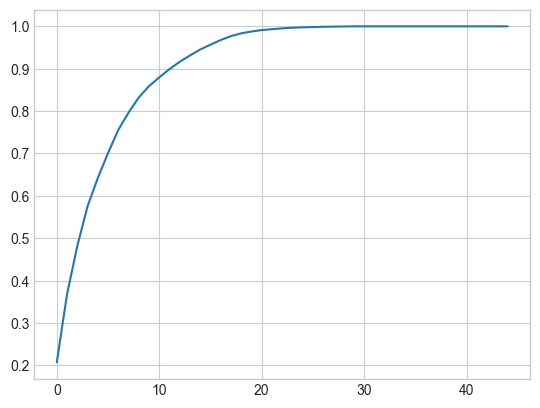

In [24]:
pca = pipeline.named_steps['pca']
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("\n--- Explained Variance ---")
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
    if cum_var > 0.95: break
    print(f"PC{i+1}: Explained Variance = {var:.3f}, Cumulative Variance = {cum_var:.3f}")

plt.plot(range(len(cumulative_variance)), cumulative_variance)
with open("cumulative_variance.tsv", 'w') as cumulative_variance_file:
    cumulative_variance_file.write("PC\tcum_var\n")
    cumulative_variance_file.write("0\t0\n")
    [cumulative_variance_file.write(f"{i+1}\t{cum_var*100}\n") for i, cum_var in enumerate(cumulative_variance) if cum_var < 0.9995]
    
loadings = au.get_component_loadings(pipeline, numerical_cols, categorical_cols)
for pc in ["PC1", "PC2", "PC3", "PC4"]:
    au.export_component_loadings(loadings, pc, {}, f"{pc}.txt", 12)

print("\n--- Principal Component Loadings ---")
display(loadings.round(3))
print("Sparseness of top 3 loadings:", np.mean(au.get_loadings_sparseness(loadings.to_numpy()[:,:3])))

### Top weights for the first four components

In [7]:
display(loadings["PC1"].sort_values(key=abs, ascending=False).round(3)[:16])

Switch Rate                                               0.398
Task 2 Cue Type Mapped_TCT2_NA                           -0.249
Task 2 Difficulty is NA_1                                -0.249
Task 2 Stimulus-Response Mapping Mapped_SRM2_NA          -0.249
Task 2 Difficulty is NA_0                                 0.249
Task 2 CSI is NA_1                                       -0.247
Task 2 CSI is NA_0                                        0.247
Response Set Overlap Mapped_RSO_NA                       -0.245
Intra-Trial Task Relationship Mapped_ITTR_NA             -0.241
Intra-Trial Task Relationship Mapped_ITTR_Different       0.222
Trial Transition Type Mapped_TTT_Pure                    -0.215
Task 2 Response Probability                               0.192
Task 2 Cue Type Mapped_TCT2_Implicit                      0.185
Task 2 Stimulus-Response Mapping Mapped_SRM2_Arbitrary    0.183
Task 1 Difficulty                                        -0.172
Task 2 CSI                              

In [8]:
display(loadings["PC2"].sort_values(key=abs, ascending=False).round(3)[:16])

Task 2 CSI                                  0.460
Task 1 CSI                                  0.453
Task 2 Response Probability                -0.423
Inter-task SOA                             -0.196
Task 1 Difficulty                          -0.188
Task 2 Cue Type Mapped_TCT2_Implicit       -0.171
Inter-task SOA is NA_1                      0.168
Inter-task SOA is NA_0                     -0.168
Switch Rate                                 0.164
Task 1 Cue Type Mapped_TCT_Arbitrary        0.147
Task 1 Cue Type Mapped_TCT_Implicit        -0.147
Task 2 Difficulty                          -0.143
Task 2 Cue Type Mapped_TCT2_Arbitrary       0.140
RSI                                         0.138
Response Set Overlap Mapped_RSO_Disjoint   -0.123
Trial Transition Type Mapped_TTT_Pure      -0.117
Name: PC2, dtype: float64

In [9]:
display(loadings["PC3"].sort_values(key=abs, ascending=False).round(3)[:16])

Task 1 CSI                                   0.435
RSI                                          0.375
Task 2 Response Probability                  0.364
Task 2 CSI                                   0.360
Task 1 Difficulty                            0.288
Distractor SOA                              -0.255
Inter-task SOA                               0.218
Task 2 Difficulty                            0.195
Inter-task SOA is NA_0                       0.150
Inter-task SOA is NA_1                      -0.150
Distractor SOA is NA_1                       0.135
Distractor SOA is NA_0                      -0.135
Trial Transition Type Mapped_TTT_Pure        0.117
Switch Rate                                 -0.117
Response Set Overlap Mapped_RSO_Disjoint     0.110
Response Set Overlap Mapped_RSO_Identical   -0.106
Name: PC3, dtype: float64

In [10]:
display(loadings["PC4"].sort_values(key=abs, ascending=False).round(3)[:16])

Task 2 Difficulty                                          0.672
Task 1 Difficulty                                          0.460
RSI                                                       -0.248
Inter-task SOA                                            -0.177
Task 1 Stimulus-Response Mapping Mapped_SRM_Compatible     0.172
Task 1 Stimulus-Response Mapping Mapped_SRM_Arbitrary     -0.163
Distractor SOA is NA_0                                     0.139
Distractor SOA is NA_1                                    -0.139
Distractor SOA                                             0.134
Task 2 Cue Type Mapped_TCT2_Arbitrary                      0.114
Task 1 Cue Type Mapped_TCT_Arbitrary                       0.104
Task 1 Cue Type Mapped_TCT_Implicit                       -0.104
Intra-Trial Task Relationship Mapped_ITTR_Different        0.104
Task 2 Response Probability                               -0.099
Task 1 CSI                                                -0.081
Task 2 Stimulus-Response 

### Find Centroids of Paradigms and Interpolate Them

### Plot Experimental Conditions

In [21]:
# --- 5. Define Tooltip Columns ---
tooltip_cols = [
    alt.Tooltip('Experiment:N', title='Experiment'),
    alt.Tooltip('Paradigm:N', title='Paradigm Class'),
    alt.Tooltip('Task 2 Response Probability:Q', title='T2 Response Probability', format='.2f'),
    alt.Tooltip('Inter-task SOA:N', title='Inter-task SOA'),
    alt.Tooltip('Distractor SOA:N', title='Distractor SOA'),
    alt.Tooltip('Task 1 CSI:Q', title='T1 CSI', format='.0f'),
    alt.Tooltip('Task 2 CSI:Q', title='T2 CSI', format='.0f'),
    alt.Tooltip('RSI:Q', title='RSI', format='.0f'),
    alt.Tooltip('RSI is Predictable:N', title='RSI Predictable'),
    alt.Tooltip('Switch Rate:Q', title='Switch Rate (%)', format='.1f'),
    alt.Tooltip('Trial Transition Type:N', title='Transition Type'),
    alt.Tooltip('Stimulus Bivalence & Congruency:N', title='Stimulus Bivalence & Congruency'),
    alt.Tooltip('Response Set Overlap:N', title='Response Set Overlap'),
    alt.Tooltip('Task 1 Stimulus-Response Mapping:N', title='T1 Stimulus-Response Mapping'),
    alt.Tooltip('Task 2 Stimulus-Response Mapping:N', title='T2 Stimulus-Response Mapping'),
    alt.Tooltip('Task 1 Difficulty:Q', title='T1 Difficulty', format='.1f'),
    alt.Tooltip('Task 2 Difficulty:Q', title='T2 Difficulty', format='.1f'),
    alt.Tooltip('Task 2 CSI is NA:N', title='T2 CSI is N/A'),
    alt.Tooltip('Task 2 Difficulty is NA:N', title='T2 Difficulty is N/A'),
    alt.Tooltip('Inter-task SOA is NA:N', title='Inter-task SOA is N/A'),
    alt.Tooltip('Distractor SOA is NA:N', title='Distractor SOA is N/A')
]
# --- 1. Combine data and calculate centroids ---
plot_df = pd.concat([
    df_processed.reset_index(drop=True),
    pca_df.reset_index(drop=True)
], axis=1)
plot_df['Point Type'] = 'Empirical Data'

centroids_df = au.find_centroids(plot_df[[c for c in plot_df.columns if c.startswith("PC")] + ["Paradigm"]], paradigm_col='Paradigm')
centroids_df = pd.DataFrame.from_dict(centroids_df, orient='index').reset_index()
centroids_df = centroids_df.rename(columns={'index': 'Paradigm'})
centroids_df['Point Type'] = 'Centroid'

# --- 2. Generate interpolated points using the new utility function ---
interpolation_pairs = [
    ('Dual-Task_PRP', 'Task Switching'),
    ('Dual-Task_PRP', 'Interference'),
    ('Task Switching', 'Interference')
]

model_artifacts_pca = {'type': 'pca', 'pipeline': pipeline}

interpolated_df = au.generate_interpolated_points(
    latent_space_df=plot_df,
    model_artifacts=model_artifacts_pca,
    interpolation_pairs=interpolation_pairs
)

# --- 3. Combine all dataframes for plotting ---
final_plot_df = pd.concat([plot_df, centroids_df, interpolated_df], ignore_index=True)
final_plot_df['Parent1'] = final_plot_df['Parent1'].fillna('N/A')
final_plot_df['Parent2'] = final_plot_df['Parent2'].fillna('N/A')
final_plot_df = plot.add_na_mask_from_flag(final_plot_df)

# Now, call the plotting function from plot.py
# (Assuming you have also moved the plotting logic there)
pca_chart = plot.create_latent_space_plot(final_plot_df, "PC1", "PC2", "PC1 (Procedural Stability <-> Dynamic Coordination)",
                                          "PC2 (Proactive Preparation vs. Reactive Dual-Task Coordination)",
                                          "Cognitive Control Experimental Conditions", tooltip_cols,
                                          has_interpolation=True, output_filename="pca_plot.json")
pca_chart

[autoreload of analysis_utils failed: Traceback (most recent call last):
  File "/Users/syntactic/miniconda3/envs/thesis/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
  File "/Users/syntactic/miniconda3/envs/thesis/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 483, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Users/syntactic/miniconda3/envs/thesis/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 991, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1129, in get_code
  File "<frozen importlib._bootstrap_external>", line 1059, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/Users/syntactic/CodeSandbox/Javascript/super-

alt.LayerChart(...)

#### Sparseness Measure of first four PCs (to match MOFA+'s number of factors)

In [12]:
np.mean(au.get_loadings_sparseness(loadings[["PC1", "PC2", "PC3", "PC4"]].to_numpy()))

0.37448643419394917

#### Paradigm Separation Validation

In [26]:
au.validate_paradigm_separation(plot_df, ["PC1", "PC2"], target_col='Paradigm', repeats=50)

{'repeats': 50,
 'random_seeds': [42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91],
 'accuracy': 0.9573333333333335,
 'accuracy_sd': 0.03986371340277399,
 'macro_f1': 0.8590277777777777,
 'macro_f1_sd': 0.13283149598913122,
 'classification_report': {'Dual-Task_PRP': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 4.0},
  'Interference': {'precision': 0.8,
   'recall': 1.0,
   'f1-score': 0.8888888888888888,
   'support': 4.0},
  'Single-Task': {'precision': 0.0,
   'recall': 0.0,
   'f1-score': 0.0,
   'support': 1.0},
  'Task Switching': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 6.0},
  'accuracy': 0.9333333333333333,
  'macro avg': {'precision': 0.7,
   'recall': 0.75,
   'f1-score': 0.7